**1. Model setup**

In [6]:
# Imports
from numpy import count_nonzero,exp,expand_dims,linspace,log,tile
from scipy import stats
from types import SimpleNamespace

#Deterministic Growth Model.
class planner():

    #Constructor.
    def __init__(self,**kwargs):
        print('--------------------------------------------------------------------------------------------------')
        print('Model')
        print('--------------------------------------------------------------------------------------------------\n')
        print('   The model is the deterministic growth model and is solved via Value Function Iteration.')

        print('\n--------------------------------------------------------------------------------------------------')
        print('Household')
        print('--------------------------------------------------------------------------------------------------\n')
        print('   The household is infintely-lived.')
        print('   It derives utility from consumption.')
        print('    -> He/she can saves capital, which is used in production, for next period.')

    #Set up model.
    def setup(self,**kwargs):

        # Namespace for parameters, grids, and utility function.
        setattr(self,'par',SimpleNamespace())
        par = self.par

        print('\n--------------------------------------------------------------------------------')
        print('Parameters:')
        print('--------------------------------------------------------------------------------\n')

        # Preferences.
        par.beta = 0.96 # Discount factor.
        par.sigma = 2.00 # CRRA.

        par.theta = 1.00 # Weight on public infrastructure: Higher values mean that public infrastructure has a higher weight in the utility function.

        # Technology.

        par.alpha = 0.33 # Capital share of income.
        par.delta = 0.05 # Capital depreciation rate.

        par.sigma_eps = 0.07 # Std. dev of productivity shocks.
        par.rho = 0.90 # Persistence of AR(1) process.
        par.mu = 0.0 # Intercept of AR(1) process.

        # Simulation parameters.
        par.seed_sim = 2025 # Seed for simulation.
        par.T = 100 # Number of time periods.

        # Set up capital grid.
        par.kss = (par.alpha/((1.0/par.beta)-1+par.delta))**(1.0/(1.0-par.alpha)) # Steady state capital.

        par.klen = 300 # Grid size for k.
        par.kmax = 1.25*par.kss # Upper bound for k.
        par.kmin = 0.75*par.kss # Minimum k.

        # Discretize productivity.
        par.Alen = 7 # Grid size for A.
        par.m = 3.0 # Scaling parameter for Tauchen.

        # Update parameter values to kwarg values if you don't want the default values.
        for key,val in kwargs.items():
            setattr(par,key,val)

        #assert par.main != None
        #assert par.figout != None
        assert par.beta > 0 and par.beta < 1.00
        assert par.sigma >= 1.00
        assert par.theta > 0
        assert par.alpha > 0 and par.alpha < 1.00
        assert par.delta >= 0 and par.delta <= 1.00
        assert par.sigma_eps > 0
        assert abs(par.rho) < 1
        assert par.Alen > 3
        assert par.m > 0.0
        assert par.klen > 5
        assert par.kmax > par.kmin

        # Set up capital grid.
        par.kgrid = linspace(par.kmin,par.kmax,par.klen) # Equally spaced, linear grid for k (and k').

        # Discretize productivity.
        Agrid,pmat = tauchen(par.mu,par.rho,par.sigma_eps,par.Alen,par.m) # Tauchen's Method to discretize the AR(1) process for log productivity.
        par.Agrid = exp(Agrid) # The AR(1) is in logs so exponentiate it to get A.
        par.pmat = pmat # Transition matrix.

        # Utility function.
        par.util = util

        print('beta: ',par.beta)
        print('sigma: ',par.sigma)
        print('theta: ',par.theta)
        print('kmin: ',par.kmin)
        print('kmax: ',par.kmax)
        print('alpha: ',par.alpha)
        print('delta: ',par.delta)
        print('sigma_eps: ',par.sigma_eps)
        print('rho: ',par.rho)
        print('mu: ',par.mu)

#CRRA Utility Function.
def util(c,g,sigma,theta):

    if sigma == 1:
        u = log(c) + theta*log(g) # Log utility.
    else:
        u = ((c*(g**theta))**(1.0-sigma))/(1.0-sigma) # CRRA utility.

    return u

#Tauchen's Method.
def tauchen(mu,rho,sigma,N,m):

    #Construct equally spaced grid.

    ar_mean = mu/(1.0-rho) # The mean of a stationary AR(1) process is mu/(1-rho).
    ar_sd = sigma/((1.0-rho**2.0)**(1/2)) # The std. dev of a stationary AR(1) process is sigma/sqrt(1-rho^2)

    y1 = ar_mean-(m*ar_sd) # Smallest grid point is the mean of the AR(1) process minus m*std.dev of AR(1) process.
    yn = ar_mean+(m*ar_sd) # Largest grid point is the mean of the AR(1) process plus m*std.dev of AR(1) process.

    y,d = linspace(y1,yn,N,endpoint=True,retstep=True) # Equally spaced grid. Include endpoint (endpoint=True) and record stepsize, d (retstep=True).

    #Compute transition probability matrix from state j (row) to k (column).

    ymatk = tile(expand_dims(y,axis=0),(N,1)) # Container for state next period.
    ymatj = mu+rho*ymatk.T # States this period.

    # In the following, loc and scale are the mean and std used to standardize the variable. # For example, norm.cdf(x,loc=y,scale=s) is the standard normal CDF evaluated at (x-y)/s.
    pmat = stats.norm.cdf(ymatk,loc=ymatj-(d/2.0),scale=sigma)-stats.norm.cdf(ymatk,loc=ymatj+(d/2.0),scale=sigma) # Transition probabilities to state 2, ..., N-1.
    pmat[:,0] = stats.norm.cdf(y[0],loc=mu+rho*y-(d/2.0),scale=sigma) # Transition probabilities to state 1.
    pmat[:,N-1] = 1.0-stats.norm.cdf(y[N-1],loc=mu+rho*y+(d/2.0),scale=sigma) # Transition probabilities to state N.

    #Output.

    y = expand_dims(y,axis=0) # Convert 0-dimensional array to a row vector.

    if count_nonzero(pmat.sum(axis=1)<0.999999) > 0:
        raise Exception("Some columns of transition matrix don't sum to 1.")

    return y,pmat

**2. Solve the model**

In [7]:
#Imports
from numpy import argmax,expand_dims,inf,squeeze,tile,zeros,seterr
from numpy.linalg import norm
from scipy.optimize import fminbound
from types import SimpleNamespace
import time
seterr(all='ignore')

#Solve the model using VFI.
def plan_allocations(myClass):

    print('\n--------------------------------------------------------------------------------------------------')
    print('Solving the Model by Value Function Iteration')
    print('--------------------------------------------------------------------------------------------------\n')

    # Namespace for optimal policy funtions.
    setattr(myClass,'sol',SimpleNamespace())
    sol = myClass.sol

    # Model parameters, grids and functions.

    par = myClass.par # Parameters.

    beta = par.beta # Discount factor.
    sigma = par.sigma # CRRA.
    theta = par.theta # Weight on infrastructure

    alpha = par.alpha # Capital share of income.
    delta = par.delta # Depreciation rate

    klen = par.klen # Grid size for k.
    kgrid = par.kgrid # Grid for k (state and choice).

    Alen = par.Alen # Grid size for A.
    Agrid = par.Agrid[0] # Grid for A.
    pmat = par.pmat # Grid for A.

    kmat = tile(expand_dims(kgrid,axis=1),(1,Alen)) # k for each value of A.
    Amat = tile(expand_dims(Agrid,axis=0),(klen,1)) # A for each value of k.

    util = par.util # Utility function.
    g0 = zeros((klen,klen,Alen))# Container for g.

    t0 = time.time()

    # Solve for Public Infrastructure.
    print('--------------------------------------Solving for Public Infrastructure------------------------------------\n')
    for h1 in range(0,klen): # Loop over k state.
        for h2 in range(0,klen): # Loop over k choice.
            for h3 in range(0,Alen): # Loop over A state.
                # Intratemporal condition.
                foc = lambda g: intra_foc(g,kgrid[h2],Agrid[h3],kgrid[h1],alpha,delta,sigma,theta)
                g0[h1,h2,h3] = fminbound(foc,0.0,1.0)

        # Print counter.
        if h1%25 == 0:
            print('Capital State: ',h1,'.\n')

    print('--------------------------------------Iterating on Bellman Eq.------------------------------------\n')

    # Value Function Iteration.
    y0 = Amat*(kmat**alpha)*(squeeze(g0[:,1,:])**(1.0-alpha)) # Given combinations of k and A and the value of g associated with the lowest possible k'.
    i0 = delta*kmat # In steady state, k=k'=k*.
    c0 = y0-i0 # Steady-state consumption.
    c0[c0<0.0] = 0.0
    v0 = util(c0,squeeze(g0[:,1,:]),sigma,theta)/(1.0-beta) # Guess of value function for each value of k.
    v0[c0<=0.0] = -inf # Set the value function to negative infinity number when c <= 0.

    crit = 1e-6;
    maxiter = 10000;
    diff = 1;
    iter = 0;

    while (diff > crit) and (iter < maxiter): # Iterate on the Bellman Equation until convergence.

        v1 = zeros((klen,Alen)) # Container for V.
        k1 = zeros((klen,Alen)) # Container for k'.
        g1 = zeros((klen,Alen)) # Container for g.

        for p in range(0,klen): # Loop over the k-states.
            for j in range(0,Alen): # Loop over the A-states.

                # Macro variables.
                y = Agrid[j]*(kgrid[p]**alpha)*(squeeze(g0[p,:,j])**(1.0-alpha)) # Output in the "last period", given combinations of k and A and the value of g associated with the lowest possible k'.
                i = kgrid-((1-delta)*kgrid[p]) # Possible values for investment, i=k'-(1-delta)k, when choosing k' from kgrid and given k.
                c = y-i # Possible values for consumption, c = y-i, given y and i.
                c[c<0.0] = 0.0

                # Solve the maximization problem.
                ev = squeeze(v0@pmat[j,:].T); #  The next-period value function is the expected value function over each possible next-period A, conditional on the current state j.
                vall = util(c,g0[p,:,j],sigma,theta) + beta*ev # Compute the value function for each choice of k', given k.
                vall[c<=0.0] = -inf # Set the value function to negative infinity number when c <= 0.
                v1[p,j] = max(vall) # Maximize: vmax is the maximized value function; ind is where it is in the grid.
                k1[p,j] = kgrid[argmax(vall)] # Optimal k'.
                g1[p,j] = g0[p,argmax(vall),j] # Choice of g given k,k', and A.

        diff = norm(v1-v0) # Check convergence.
        v0 = v1; # Update guess.

        iter = iter + 1; # Update counter.

        # Print counter.
        if iter%25 == 0:
            print('Iteration: ',iter,'.\n')

    t1 = time.time()
    print('Elapsed time is ',t1-t0,' seconds.')
    print('Converged in ',iter,' iterations.')

    # Macro variables, value, and policy functions.
    sol.y = Amat*(kmat**alpha)*(g1**(1.0-alpha)) # Output.
    sol.k = k1 # Capital policy function.
    sol.g = g1 # public infrastructure policy function.
    sol.i = k1-((1.0-delta)*kmat) # Investment policy function.
    sol.c = sol.y-sol.i # Consumption policy function.
    sol.c[sol.c<0.0] = 0.0
    sol.v = v1 # Value function.
    sol.v[sol.c<=0.0] = -inf

# Intra-temporal conditions for labor.
def intra_foc(g,kp,A,k,alpha,delta,sigma,theta):

    c = (A*(k**alpha)*(g**(1.0-alpha)))+((1.0-delta)*k-kp)
    mpl = A*(1.0-alpha)*((k/g)**alpha)

    # Public infrastructure
    ug = (c*theta*(g**(theta-1.0)))*(c*(g**theta))**(-sigma)

    # Consumption.
    if sigma == 1.0:
        uc = 1.0/c # Log utility.
    else:
        uc = (g**(theta))*((c*(g**theta))**(-sigma)) # CRRA utility.

    # Total.
    ucg = uc*mpl + ug

    return ucg



**3. Simulates the model**

In [8]:
#Imports
from numpy import cumsum,linspace,squeeze,where,zeros
from numpy.random import choice,rand,seed
from numpy.linalg import matrix_power
from types import SimpleNamespace

#Simulate the model.
def grow_economy(myClass):

    print('\n--------------------------------------------------------------------------------------------------')
    print('Simulate the Model')
    print('--------------------------------------------------------------------------------------------------\n')

    # Namespace for simulation.
    setattr(myClass,'sim',SimpleNamespace())
    sim = myClass.sim

    # Model parameters, grids and functions.

    par = myClass.par # Parameters.
    sol = myClass.sol # Policy functions.

    sigma = par.sigma # CRRA.
    theta = par.theta # Weight on leisure.
    util = par.util # Utility function.
    seed_sim = par.seed_sim # Seed for simulation.

    klen = par.klen # Capital grid size.
    Alen = par.Alen # Productivity grid size.
    kgrid = par.kgrid # Capital today (state).
    Agrid = par.Agrid[0] # Productivity today (state).
    pmat = par.pmat # Productivity today (state).

    yout = sol.y # Production function.
    kpol = sol.k # Policy function for capital.
    cpol = sol.c # Policy function for consumption.
    ipol = sol.i # Policy function for investment.
    gpol = sol.g # Policy function for public infrastructure.

    T = par.T # Time periods.
    Asim = zeros(par.T*2) # Container for simulated productivity.
    ysim = zeros(par.T*2) # Container for simulated output.
    ksim = zeros(par.T*2) # Container for simulated capital stock.
    csim = zeros(par.T*2) # Container for simulated consumption.
    gsim = zeros(par.T*2) # Container for simulated public infrastructure.
    isim = zeros(par.T*2) # Container for simulated investment.
    usim = zeros(par.T*2) # Container for simulated utility.

    # Begin simulation.

    seed(seed_sim)

    pmat0 = matrix_power(pmat,1000)
    pmat0 = pmat0[0,:] # % Stationary distribution.
    cmat = cumsum(par.pmat,axis=1) # CDF matrix.

    A0_ind = choice(linspace(0,Alen,Alen,endpoint=False,dtype=int),1,p=pmat0) # Index for initial productivity.
    k0_ind = choice(linspace(0,klen,klen,endpoint=False,dtype=int),1) # Index for initial capital stock.

    Asim[0] = Agrid[A0_ind] # Productivity in period 1.
    ysim[0] = yout[k0_ind,A0_ind] # Output in period 1 given k0 and A0.
    csim[0] = cpol[k0_ind,A0_ind] # Consumption in period 1 given k0 and A0.
    ksim[0] = kpol[k0_ind,A0_ind] # Capital choice for period 2 given k0.
    gsim[0] = gpol[k0_ind,A0_ind] # Labor supply in period 1 given k0 and A0.
    isim[0] = ipol[k0_ind,A0_ind] # Investment in period 1 given k0 and A0.
    usim[0] = util(csim[0],gsim[0],sigma,theta) # Utility in period 1 given k0 and A0.

    A1_ind = where(rand(1)<=squeeze(cmat[A0_ind,:])) # Draw productivity for next period.
    At_ind = A1_ind[0][0]

    # Simulate endogenous variables.

    for j in range(1,T*2): # Time loop.
        kt_ind = where(ksim[j-1]==kgrid); # Capital choice in the previous period is the state today. Find where the latter is on the grid.
        Asim[j] = Agrid[At_ind] # Productivity in period t.
        ysim[j] = yout[kt_ind,At_ind] # Output in period t.
        csim[j] = cpol[kt_ind,At_ind] # Consumption in period t.
        gsim[j] = gpol[kt_ind,At_ind] # Public infrastructure for period t.
        ksim[j] = kpol[kt_ind,At_ind] # Capital stock for period t+1.
        isim[j] = ipol[kt_ind,At_ind] # Investment in period t.
        usim[j] = util(csim[j],gsim[j],sigma,theta) # Utility in period t.
        A1_ind = where(rand(1)<=squeeze(cmat[At_ind,:])) # Draw next state.
        At_ind = A1_ind[0][0] # State next period.

    # Burn the first half.
    sim.Asim = Asim[T:2*T+1] # Simulated productivity.
    sim.ysim = ysim[T:2*T+1] # Simulated output.
    sim.ksim = ksim[T:2*T+1] # Simulated capital choice.
    sim.csim = csim[T:2*T+1] # Simulated consumption.
    sim.gsim = gsim[T:2*T+1] # Simulated labor supply.
    sim.isim = isim[T:2*T+1] # Simulated investment.
    sim.usim = usim[T:2*T+1] # Simulated utility.

**4. Graphs**

In [9]:
# Imports
from matplotlib.pyplot import close,figure,plot,xlabel,ylabel,title,savefig,show
from numpy import linspace
import os

# Plot the model functions and simulations.
def track_growth(myClass):

    # Model parameters, policy and value functions, and simulations.
    par = myClass.par # Parameters.
    sol = myClass.sol # Policy functions.
    sim = myClass.sim # Simulations.

    # Create the output directory if it doesn't exist
    os.makedirs(par.figout, exist_ok=True) # Create the directory if it doesn't exist

    # Production function.

    figure(1)
    plot(par.kgrid,sol.y)
    xlabel('$k_{t}$')
    ylabel('$y_{t}$')
    title('Production Function')

    figname = os.path.join(par.figout, "ypol.png")
    print(figname)
    savefig(figname)

    # Plot capital policy function.

    figure(2)
    plot(par.kgrid,sol.k)
    xlabel('$k_{t}$')
    ylabel('$k_{t+1}$')
    title('Capital Policy Function')

    figname = os.path.join(par.figout, "kpol.png")
    savefig(figname)

    # Plot consumption policy function.

    figure(3)
    plot(par.kgrid,sol.c)
    xlabel('$k_{t}$')
    ylabel('$c_{t}$')
    title('Consumption Policy Function')

    figname = os.path.join(par.figout, "cpol.png")
    savefig(figname)

    # Plot investment policy function.

    figure(4)
    plot(par.kgrid,sol.i)
    xlabel('$k_{t}$')
    ylabel('$i_{t}$')
    title('Investment Policy Function')

    figname = os.path.join(par.figout, "ipol.png")
    savefig(figname)

    # Plot public infrastructure policy function.

    figure(5)
    plot(par.kgrid,sol.g)
    xlabel('$k_{t}$')
    ylabel('$g_t$')
    title('Public Infrastructure Policy Function')

    figname = os.path.join(par.figout, "gpol.png")
    savefig(figname)

    # Plot value function.

    figure(6)
    plot(par.kgrid,sol.v)
    xlabel('$k_{t}$')
    ylabel('$V_t(k_t)$')
    title('Value Function')

    figname = os.path.join(par.figout, "vfun.png")
    savefig(figname)

    # Plot simulated output.

    tgrid = linspace(1,par.T,par.T,dtype=int)

    figure(7)
    plot(tgrid,sim.ysim)
    xlabel('Time')
    ylabel('$y^{sim}_t$')
    title('Simulated Output')

    figname = os.path.join(par.figout, "ysim.png")
    savefig(figname)

    # Plot simulated capital choice.

    figure(8)
    plot(tgrid,sim.ksim)
    xlabel('Time')
    ylabel('$k^{sim}_{t+1}$')
    title('Simulated Capital Choice')

    figname = os.path.join(par.figout, "ksim.png")
    savefig(figname)

    # Plot simulated consumption.

    figure(9)
    plot(tgrid,sim.csim)
    xlabel('Time')
    ylabel('$c^{sim}_{t}$')
    title('Simulated Consumption')

    figname = os.path.join(par.figout, "csim.png")
    savefig(figname)

    # Plot simulated investment.

    figure(10)
    plot(tgrid,sim.isim)
    xlabel('Time')
    ylabel('$i^{sim}_{t}$')
    title('Simulated Investment')

    figname = os.path.join(par.figout, "isim.png")
    savefig(figname)

    # Plot simulated utility.

    figure(11)
    plot(tgrid,sim.usim)
    xlabel('Time')
    ylabel('$u^{sim}_t$')
    title('Simulated Utility')

    figname = os.path.join(par.figout, "usim.png")
    savefig(figname)

    # Plot simulated productivity.

    figure(12)
    plot(tgrid,sim.Asim)
    xlabel('Time')
    ylabel('$A^{sim}_t$')
    title('Simulated Productivity')

    figname = os.path.join(par.figout, "Asim.png")
    savefig(figname)

    # Plot simulated public infrastructure.

    figure(13)
    plot(tgrid,sim.gsim)
    xlabel('Time')
    ylabel('$g^{sim}_t$')
    title('Simulated Infrastructure')

    figname = os.path.join(par.figout, "gsim.png")
    savefig(figname)

--------------------------------------------------------------------------------------------------
Model
--------------------------------------------------------------------------------------------------

   The model is the deterministic growth model and is solved via Value Function Iteration.

--------------------------------------------------------------------------------------------------
Household
--------------------------------------------------------------------------------------------------

   The household is infintely-lived.
   It derives utility from consumption.
    -> He/she can saves capital, which is used in production, for next period.

--------------------------------------------------------------------------------
Parameters:
--------------------------------------------------------------------------------

beta:  0.96
sigma:  2.0
theta:  1.0
kmin:  5.074152358079149
kmax:  8.456920596798582
alpha:  0.33
delta:  0.05
sigma_eps:  0.07
rho:  0.9
mu:  0.0

-------------

<ipython-input-8-aca4fa63b4cd>:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Asim[0] = Agrid[A0_ind] # Productivity in period 1.
<ipython-input-8-aca4fa63b4cd>:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ysim[0] = yout[k0_ind,A0_ind] # Output in period 1 given k0 and A0.
<ipython-input-8-aca4fa63b4cd>:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  csim[0] = cpol[k0_ind,A0_ind] # Consumption in period 1 given k0 and A0.
<ipython-input-8-aca4fa63b4cd>:63

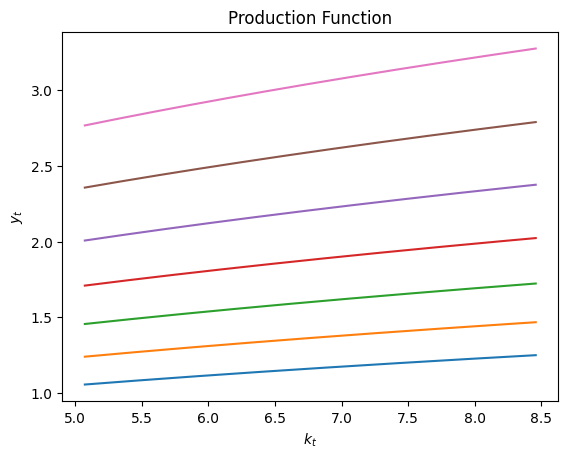

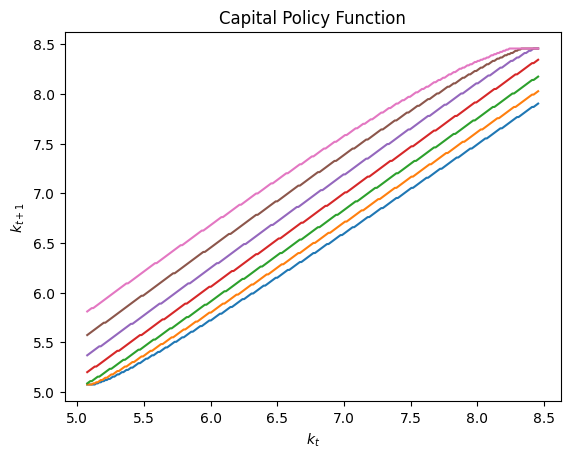

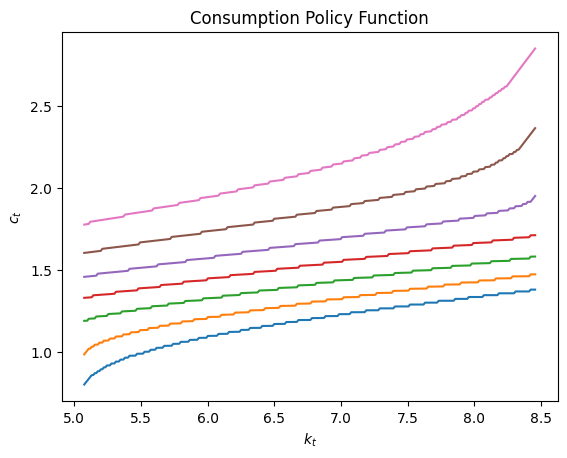

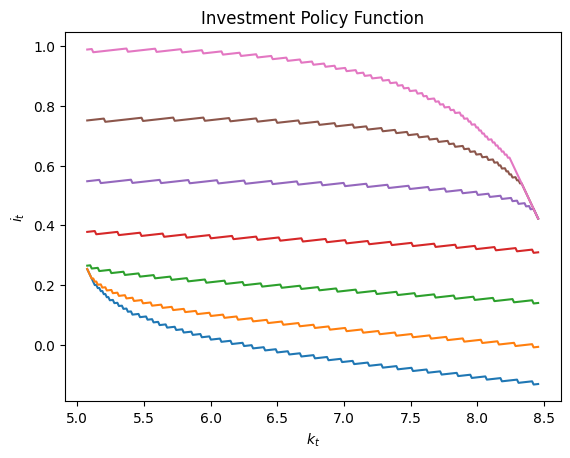

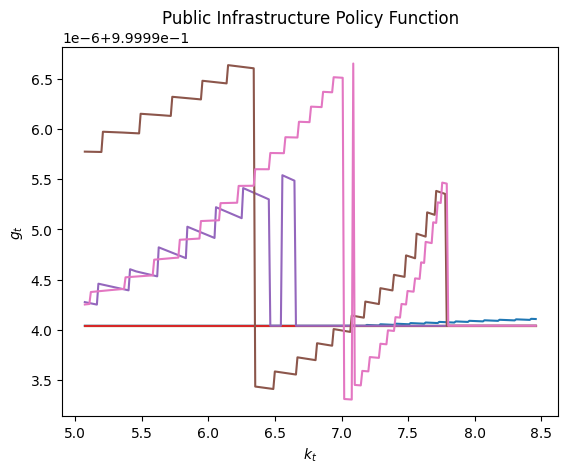

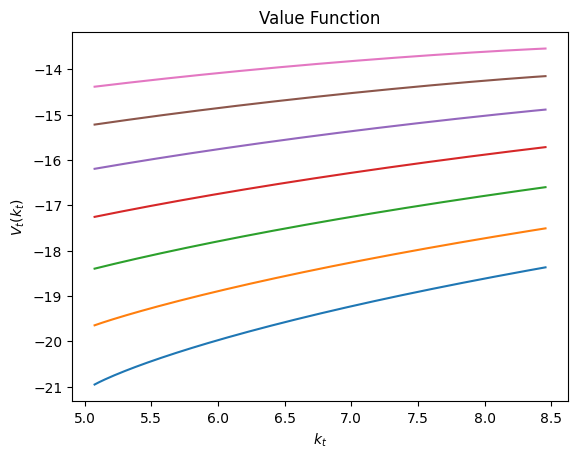

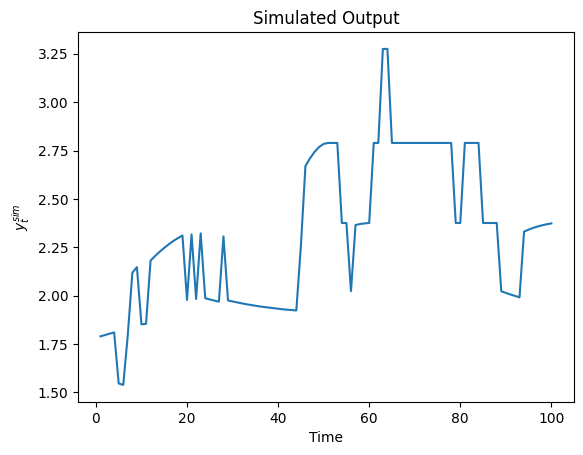

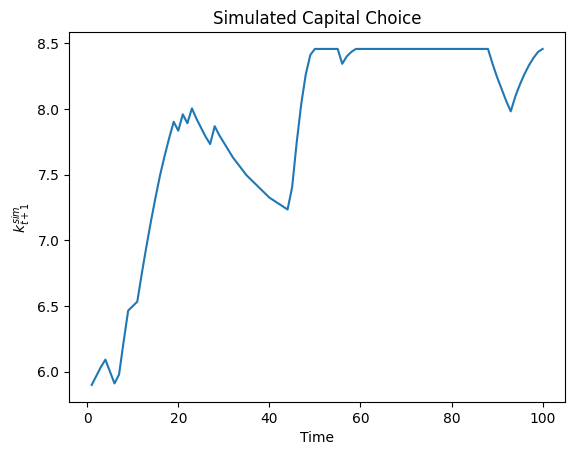

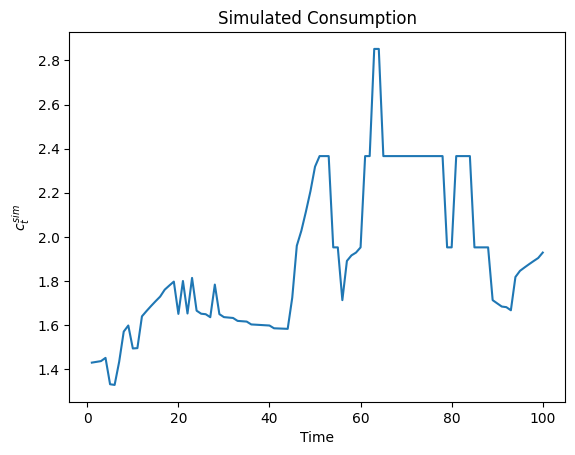

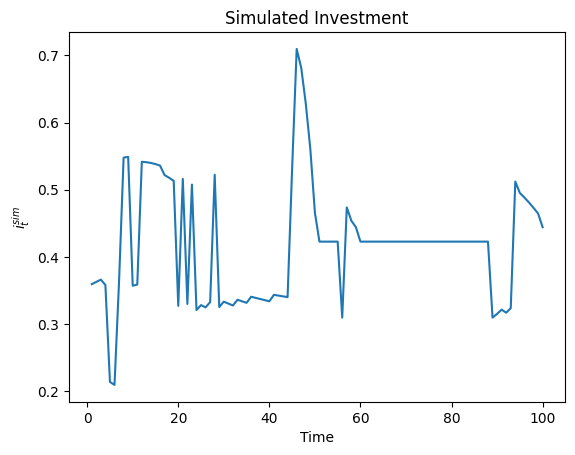

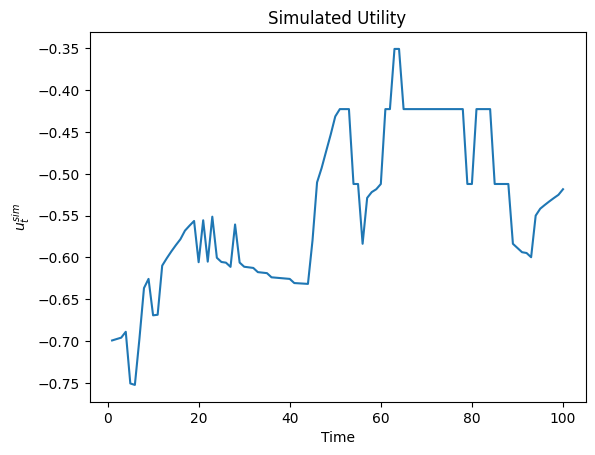

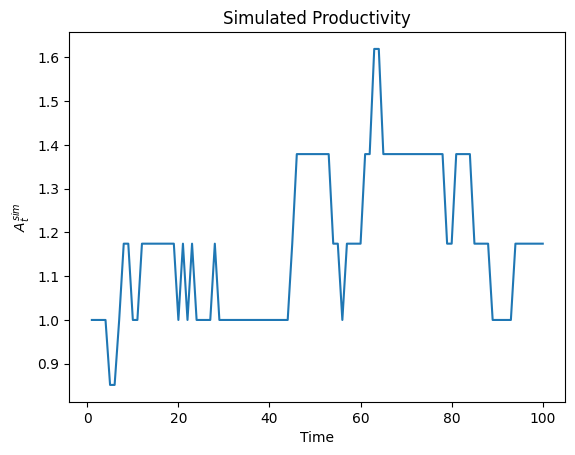

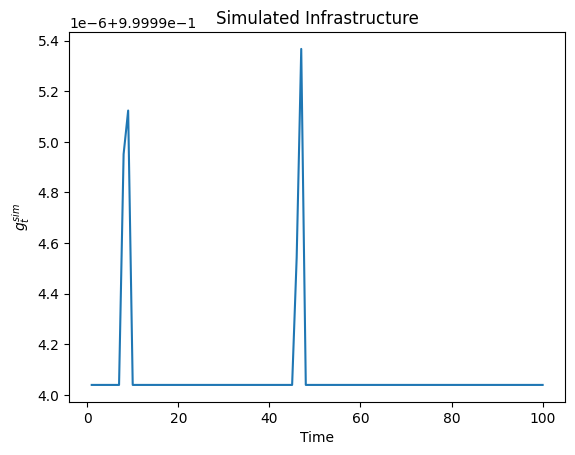

In [10]:
#%% Stochastic Growth Model.
benevolent_dictator = planner()

# Set the parameters, state space, and utility function.
benevolent_dictator.setup(beta = 0.96,sigma=2.00) # You can set the parameters here or use the defaults.
benevolent_dictator.par.figout = "output/figures"

# Solve the model.
plan_allocations(benevolent_dictator) # Obtain the policy functions for capital.

# Simulate the model.
grow_economy(benevolent_dictator) # Simulate forward in time.

# Graphs.
track_growth(benevolent_dictator) # Plot policy functions and simulations.
